# Road Following - Live demo

In this notebook, we will use model we trained to move jetBot smoothly on track. 

### Load Trained Model

We will assume that you have already downloaded ``best_steering_model_xy.pth`` to work station as instructed in "train_model.ipynb" notebook. Now, you should upload model file to JetBot in to this notebook's directory. Once that's finished there should be a file named ``best_steering_model_xy.pth`` in this notebook's directory.

> Please make sure the file has uploaded fully before calling the next cell

Execute the code below to initialize the PyTorch model. This should look very familiar from the training notebook.

In [1]:
import torchvision
import torch

model = torchvision.models.mobilenet_v3_large(pretrained=False)
model.classifier[3] = torch.nn.Linear(model.classifier[3].in_features, 2)
# model = torchvision.models.resnet18(pretrained=False)
# model = torchvision.models.resnet34(pretrained=False)
# model.fc = torch.nn.Linear(model.fc.in_features, 2)

Next, load the trained weights from the ``best_steering_model_xy.pth`` file that you uploaded.

In [2]:
model.load_state_dict(torch.load('best_steering_model_xy_mobilenet_v3_large.pth'))
# model.load_state_dict(torch.load('best_steering_model_xy_resnet18.pth'))
# model.load_state_dict(torch.load('best_steering_model_xy_resnet34.pth'))

<All keys matched successfully>

Currently, the model weights are located on the CPU memory execute the code below to transfer to the GPU device.

In [3]:
device = torch.device('cuda')
model = model.to(device)
model = model.eval().half()

### Creating the Pre-Processing Function

We have now loaded our model, but there's a slight issue. The format that we trained our model doesn't exactly match the format of the camera. To do that, we need to do some preprocessing. This involves the following steps:

1. Convert from HWC layout to CHW layout
2. Normalize using same parameters as we did during training (our camera provides values in [0, 255] range and training loaded images in [0, 1] range so we need to scale by 255.0
3. Transfer the data from CPU memory to GPU memory
4. Add a batch dimension

In [4]:
import torchvision.transforms as transforms
import torch.nn.functional as F
import cv2
import PIL.Image
import numpy as np

mean = torch.Tensor([0.485, 0.456, 0.406]).cuda().half()
std = torch.Tensor([0.229, 0.224, 0.225]).cuda().half()

def preprocess(image):
    image = PIL.Image.fromarray(image)
    image = transforms.functional.to_tensor(image).to(device).half()
    image.sub_(mean[:, None, None]).div_(std[:, None, None])
    return image[None, ...]

Awesome! We've now defined our pre-processing function which can convert images from the camera format to the neural network input format.

Now, let's start and display our camera. You should be pretty familiar with this by now. 

In [5]:
from IPython.display import display
import ipywidgets
import traitlets
from jetbot import Camera, bgr8_to_jpeg

camera = Camera()

image_widget = ipywidgets.Image()
fps_widget = ipywidgets.FloatText(description='Capture rate')

traitlets.dlink((camera, 'value'), (image_widget, 'value'), transform=bgr8_to_jpeg)
traitlets.dlink((camera, 'cap_time'), (fps_widget, 'value'))
                
display(image_widget)
display(fps_widget)

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

FloatText(value=0.0057125510000020085, description='Capture rate')

We'll also create our robot instance which we'll need to drive the motors.

In [6]:
from jetbot import Robot

robot = Robot()

Now, we will define sliders to control JetBot
> Note: We have initialize the slider values for best known configurations, however these might not work for your dataset, therefore please increase or decrease the sliders according to your setup and environment

1. Speed Control (speed_gain_slider): To start your JetBot increase ``speed_gain_slider`` 
2. Steering Gain Control (steering_gain_slider): If you see JetBot is wobbling, you need to reduce ``steering_gain_slider`` till it is smooth
3. Steering Bias control (steering_bias_slider): If you see JetBot is biased towards extreme right or extreme left side of the track, you should control this slider till JetBot start following line or track in the center.  This accounts for motor biases as well as camera offsets

> Note: You should play around above mentioned sliders with lower speed to get smooth JetBot road following behavior.

In [7]:
# speed_gain_slider = ipywidgets.FloatSlider(min=0.0, max=1.0, step=0.01, description='speed gain')
# steering_gain_slider = ipywidgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.2, description='steering gain')
# steering_dgain_slider = ipywidgets.FloatSlider(min=0.0, max=0.5, step=0.001, value=0.0, description='steering kd')
# steering_bias_slider = ipywidgets.FloatSlider(min=-0.3, max=0.3, step=0.01, value=0.0, description='steering bias')
speed_gain_slider = ipywidgets.FloatSlider(min=0.0, max=0.2, step=0.001, value=0.09, description='speed gain', readout_format='.3f')
steering_gain_slider = ipywidgets.FloatSlider(min=0.0, max=0.2, step=0.0001, value=0.02, description='steering gain', readout_format='.3f')
steering_dgain_slider = ipywidgets.FloatSlider(min=0.0, max=0.5, step=0.001, value=0.09, description='steering kd', readout_format='.3f')
steering_bias_slider = ipywidgets.FloatSlider(min=-0.3, max=0.3, step=0.01, value=0.0, description='steering bias', readout_format='.3f')

display(speed_gain_slider, steering_gain_slider, steering_dgain_slider, steering_bias_slider)

FloatSlider(value=0.09, description='speed gain', max=0.2, readout_format='.3f', step=0.001)

FloatSlider(value=0.02, description='steering gain', max=0.2, readout_format='.3f', step=0.0001)

FloatSlider(value=0.09, description='steering kd', max=0.5, readout_format='.3f', step=0.001)

FloatSlider(value=0.0, description='steering bias', max=0.3, min=-0.3, readout_format='.3f', step=0.01)

Next, let's display some sliders that will let us see what JetBot is thinking.  The x and y sliders will display the predicted x, y values.

The steering slider will display our estimated steering value.  Please remember, this value isn't the actual angle of the target, but simply a value that is
nearly proportional.  When the actual angle is ``0``, this will be zero, and it will increase / decrease with the actual angle.  

In [8]:
x_slider = ipywidgets.FloatSlider(min=-1.0, max=1.0, description='x')
y_slider = ipywidgets.FloatSlider(min=0, max=1.0, orientation='vertical', description='y')
steering_slider = ipywidgets.FloatSlider(min=-1.0, max=1.0, description='steering')
speed_slider = ipywidgets.FloatSlider(min=0, max=1.0, orientation='vertical', description='speed')

display(ipywidgets.HBox([y_slider, speed_slider]))
display(x_slider, steering_slider)

FloatSlider(value=0.0, description='x', max=1.0, min=-1.0)

FloatSlider(value=0.0, description='steering', max=1.0, min=-1.0)

Next, we'll create a function that will get called whenever the camera's value changes. This function will do the following steps

1. Pre-process the camera image
2. Execute the neural network
3. Compute the approximate steering value
4. Control the motors using proportional / derivative control (PD)

In [9]:
import time
angle = 0.0
angle_last = 0.0
et=[]

def execute(change):
    start_time = time.process_time()
    global angle, angle_last
    image = change['new']
    xy = model(preprocess(image)).detach().float().cpu().numpy().flatten()
    x = xy[0]
    y = (0.5 - xy[1]) / 2.0
    
    x_slider.value = x
    y_slider.value = y
    
    speed_slider.value = speed_gain_slider.value
    
    angle = np.arctan2(x, y)
    pid = angle * steering_gain_slider.value + (angle - angle_last) * steering_dgain_slider.value
    angle_last = angle
    
    steering_slider.value = pid + steering_bias_slider.value
    
    robot.left_motor.value = max(min(speed_slider.value + steering_slider.value, 1.0), 0.0)
    robot.right_motor.value = max(min(speed_slider.value - steering_slider.value, 1.0), 0.0)
    end_time = time.process_time()
    et.append(end_time - start_time + camera.cap_time)
execute({'new': camera.value})

Cool! We've created our neural network execution function, but now we need to attach it to the camera for processing.

We accomplish that with the observe function.

>WARNING: This code will move the robot!! Please make sure your robot has clearance and it is on Lego or Track you have collected data on. The road follower should work, but the neural network is only as good as the data it's trained on!

In [10]:
camera.observe(execute, names='value')

Awesome! If your robot is plugged in it should now be generating new commands with each new camera frame. 

You can now place JetBot on  Lego or Track you have collected data on and see whether it can follow track.

If you want to stop this behavior, you can unattach this callback by executing the code below.

Mean excution time of model : 0.187983 
Max excution time of model : 0.628634 
Min excution time of model : 0.159794 


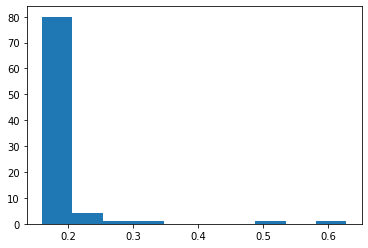

In [11]:
import time
import numpy as np, matplotlib.pyplot as plt

camera.unobserve(execute, names='value')

excute_time = np.array(et[1:])
mean_excute_time = np.mean(excute_time)
max_excute_time = np.amax(excute_time)
min_excute_time = np.amin(excute_time)
print("Mean excution time of model : %f \nMax excution time of model : %f \nMin excution time of model : %f " \
       % (mean_excute_time, max_excute_time, min_excute_time))

plt.hist(excute_time)

time.sleep(0.1)  # add a small sleep to make sure frames have finished processing

robot.stop()

Again, let's close the camera conneciton properly so that we can use the camera in other notebooks.

In [ ]:
camera.stop()

### Conclusion
That's it for this live demo! Hopefully you had some fun seeing your JetBot moving smoothly on track following the road!!!

If your JetBot wasn't following road very well, try to spot where it fails. The beauty is that we can collect more data for these failure scenarios and the JetBot should get even better :)